# Performing a full distance comparison using PSA

In this example, PSA is used to compute the mutual pairwise distances between a set of trajectories. In this notebook, we show how to perform a suitable alignment of (all frames of all) trajectories prior to a distance comparison using PSA. The purpose of this alignment step is to ensure unnecessary translations and rotations in trajetory frames are removed before distances are calculated. More details can be found in the article below:

S.L. Seyler, A. Kumar, M.F. Thorpe, and O. Beckstein, Path
Similarity Analysis: a Method for Quantifying Macromolecular
Pathways. `arXiv:1505.04807v1`_ [q-bio.QM], 2015.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Suppress FutureWarning about element-wise comparison to None
# Occurs when calling PSA plotting functions
import warnings
warnings.filterwarnings('ignore')

---
## 1) Set up input data for `PSA` using `MDAnalysis`

In [2]:
from MDAnalysis import Universe
from MDAnalysis.analysis.align import rotation_matrix
from MDAnalysis.analysis.psa import PSAnalysis
from pair_id import PairID

### A) Generate a reference structure for trajectory alignment

Read in closed/open AdK structures; work with C$_\alpha$ only

In [3]:
u_closed = Universe('structs/adk1AKE.pdb')
u_open = Universe('structs/adk4AKE.pdb')
ca_closed = u_closed.select_atoms('name CA')
ca_open = u_open.select_atoms('name CA')

Move centers-of-mass of C$_\alpha$ of each structure's CORE domain to origin

In [4]:
adkCORE_resids = "(resid 1:29 or resid 60:121 or resid 160:214)"
u_closed.atoms.translate(-ca_closed.select_atoms(adkCORE_resids).center_of_mass())
u_open.atoms.translate(-ca_open.select_atoms(adkCORE_resids).center_of_mass())

array([-1.68736987,  6.38378082,  0.03143151])

Get C$_\alpha$ CORE coordinates for each structure

In [5]:
closed_ca_core_coords = ca_closed.select_atoms(adkCORE_resids).positions
open_ca_core_coords = ca_open.select_atoms(adkCORE_resids).positions

Compute rotation matrix, R, that minimizes rmsd between the C$_\alpha$ COREs

In [6]:
R, rmsd_value = rotation_matrix(open_ca_core_coords, closed_ca_core_coords)

Rotate open structure to align its C$_\alpha$ CORE to closed structure's C$_\alpha$ CORE

In [7]:
u_open.atoms.rotate(R)

matrix([[ 0.00964436,  0.05166405,  0.99861795],
        [-0.99944836, -0.03124003,  0.0112686 ],
        [ 0.03177904, -0.9981758 ,  0.05133426]], dtype=float32)

Generate reference structure coordinates: take average positions of C$_\alpha$ COREs of open and closed structures (after C$_\alpha$ CORE alignment)

In [8]:
reference_coordinates = 0.5*(ca_closed.select_atoms(adkCORE_resids).positions
    + ca_open.select_atoms(adkCORE_resids).positions)

Generate Universe for the reference structure (using reference coordinates from above)

In [9]:
u_ref = Universe('structs/adk1AKE.pdb')
u_ref.atoms.translate(-u_ref.select_atoms(adkCORE_resids).CA.center_of_mass())
u_ref.select_atoms(adkCORE_resids).CA.set_positions(reference_coordinates)

### B) Build list of simulations from topologies and trajectories

Initialize lists for the methods on which to perform PSA. PSA will be performed for four different simulations methods with three runs for each: **DIMS**, **FRODA**, **rTMD-F**, and **rTMD-S**. Also initialize a `PSAIdentifier` object to keep track of the data corresponding to comparisons between pairs of simulations.

In [10]:
method_names = ['DIMS', 'FRODA', 'GOdMD', 'MDdMD', 'rTMD-F', 'rTMD-S',
                'ANMP', 'iENM', 'MAP', 'MENM-SD', 'MENM-SP',
                'Morph', 'LinInt']
labels = [] # Heat map labels
simulations = [] # List of simulation topology/trajectory filename pairs
universes = [] # List of MDAnalysis Universes representing simulations

For each method, get the topology and each of three total trajectories (per method). Each simulation is represented as a `(topology, trajectory)` pair of file names, which is appended to a master list of simulations.

In [11]:
for method in method_names:
    # Note: DIMS uses the PSF topology format
    topname = 'top.psf' if 'DIMS' in method or 'TMD' in method else 'top.pdb'
    pathname = 'path.dcd'
    method_dir = 'methods/{}'.format(method)
    if method is not 'LinInt':
        for run in xrange(1, 4): # 3 runs per method
            run_dir = '{}/{:03n}'.format(method_dir, run)
            topology = '{}/{}'.format(method_dir, topname)
            trajectory = '{}/{}'.format(run_dir, pathname)
            labels.append(method + '(' + str(run) + ')')
            simulations.append((topology, trajectory))
    else: # only one LinInt trajectory
        topology = '{}/{}'.format(method_dir, topname)
        trajectory = '{}/{}'.format(method_dir, pathname)
        labels.append(method)
        simulations.append((topology, trajectory))

Generate a list of universes from the list of simulations.

In [12]:
for sim in simulations:
    universes.append(Universe(*sim))

---
## 2) Compute and plot all-pairs distances using PSA

Initialize a PSA comparison from the universe list using a C$_\alpha$–trajectory representation, then generate `PSA` `Path`s from the universes.

In [13]:
ref_selection = "name CA and " + adkCORE_resids
psa_full = PSAnalysis(universes,
                      reference=u_ref, ref_select=ref_selection,
                      path_select='name CA', labels=labels)
psa_full.generate_paths(align=True)

### Computing mutual distances using Hausdorff and (discrete) Fréchet path metrics

**Hausdorff**: compute the Hausdorff distances between all unique pairs of `Path`s and store the distance matrix.

In [14]:
psa_full.run(metric='hausdorff')
hausdorff_distances = psa_full.get_pairwise_distances()

Plot clustered heat maps using Ward hierarchical clustering. The first heat map is plotted with the corresponding dendrogram and is fully labeled by the method names; the second heat map is annotated by the Hausdorff distances.

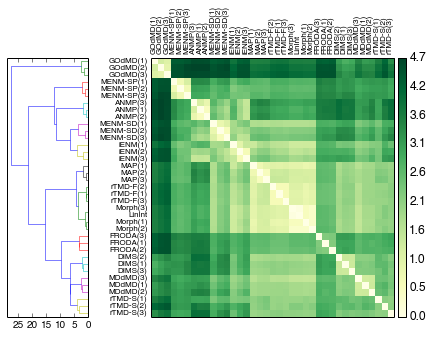

In [15]:
psa_full.plot(filename='dh_ward_psa-full.pdf', linkage='ward');

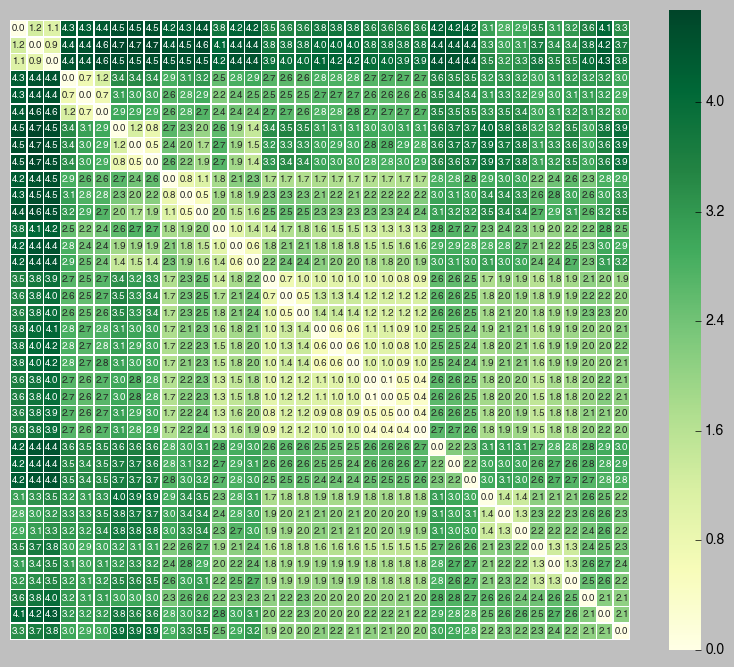

In [16]:
psa_full.plot_annotated_heatmap(filename='dh_ward_psa-full_annot.pdf', linkage='ward');

**Fréchet**: compute the (discrete) Fréchet distances between all unique pairs of `Path`s  and store the distance matrix.

In [17]:
psa_full.run(metric='discrete_frechet')
frechet_distances = psa_full.get_pairwise_distances()

As above, plot heat maps for (discrete) Fréchet distances.

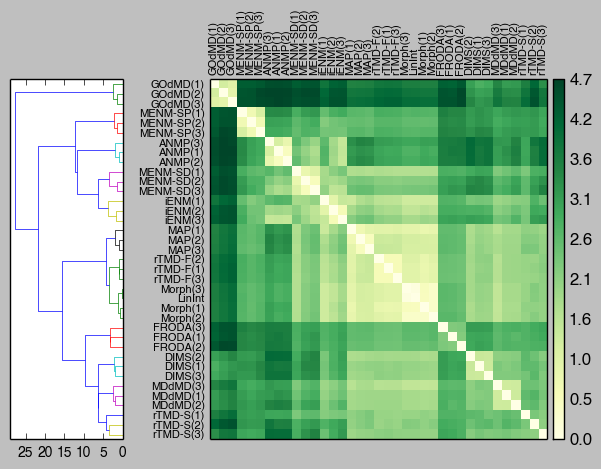

In [18]:
psa_full.plot(filename='df_ward_psa-full.pdf', linkage='ward');

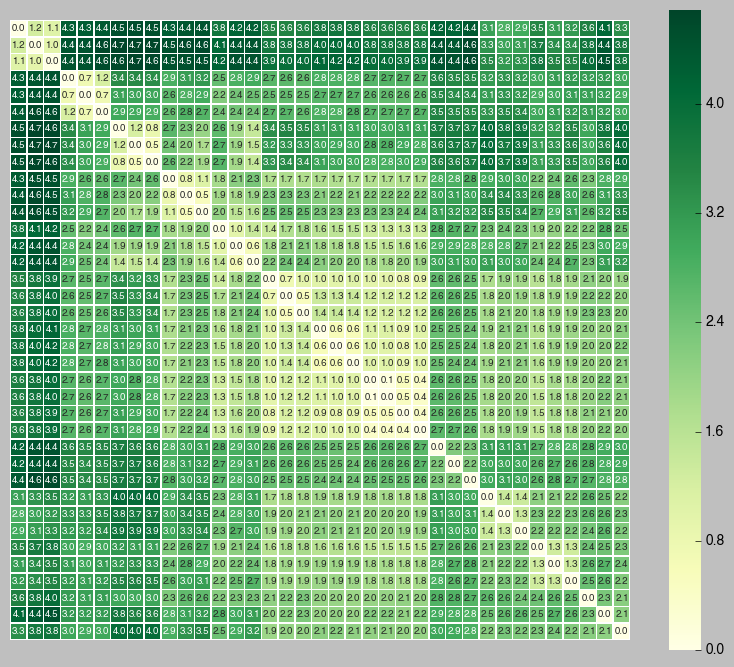

In [19]:
psa_full.plot_annotated_heatmap(filename='df_ward_psa-full_annot.pdf', linkage='ward');

---
## 3) Extract specific data from PSA

Get the Simulation IDs and PSA ID for the second DIMS simulation (DIMS 2) and third rTMD-F simulation (rTMD-F 3).

In [20]:
identifier = PairID()
for name in method_names:
    run_ids = [1] if 'LinInt' in name else [1,2,3]
    identifier.add_sim(name, run_ids)

In [21]:
sid1 = identifier.get_sim_id('DIMS 2')
sid2 = identifier.get_sim_id('rTMD-F 3')
pid = identifier.get_pair_id('DIMS 2', 'rTMD-F 3')

Use the **Simulation ID**s to locate Hausdorff and (discrete) Fréchet distances DIMS 2/rTMD-F 3 comparison:

In [22]:
print hausdorff_distances[sid1,sid2]
print frechet_distances[sid1,sid2]

1.86563951102
1.86605177133


Use the **PSA ID** when the distances are in the form of a distance vector (see `scipy.spatial.distance.squareform`)

In [23]:
from scipy.spatial.distance import squareform
hausdorff_vectorform = squareform(hausdorff_distances)
frechet_vectorform = squareform(frechet_distances)

In [25]:
print hausdorff_vectorform[pid]
print frechet_vectorform[pid]

1.86563951102
1.86605169491


Check that data obtained from the distance matrix is the same as that accessed from the distance vector

In [26]:
print hausdorff_distances[sid1,sid2] == hausdorff_vectorform[pid]
print frechet_distances[sid1,sid2] == frechet_vectorform[pid]

True
True
